### [UNHCR Refugee Data](https://www.kaggle.com/unitednations/refugee-data)  

This dataset includes 6 csv files covering:

* Asylum monthly applications opened (asylum_seekers_monthly.csv)
* Yearly progress through the refugee system (asylum_seekers.csv)
* Refugee demographics (demographics.csv)
* Yearly time series data on UNHCR’s populations of concern (time_series.csv)
* Yearly population statistics on refugees by residence and destination (persons_of_concern.csv)
* Yearly data on resettlement arrivals, with or without UNHCR assistance (resettlement.csv)

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Goal

Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

* A specified research question your model addresses
* How you chose your model specification and what alternatives you compared it to
* The practical uses of your model for an audience of interest
* Any weak points or shortcomings of your model

## Research question ideas

<ol>
    <li>What were the main identifying factor(s) / predictor(s) of recogized groups of refugees and asylees?</li>

    <li></li>
</ol>


In [2]:
path = '/Users/gemma/Documents/data science/DS bootcamp prep/datasets/refugee-data/'

monthly = pd.read_csv(path+'asylum_seekers_monthly.csv', low_memory=False)
asylees = pd.read_csv(path+'asylum_seekers.csv', low_memory=False)
demographics = pd.read_csv(path+'demographics.csv', low_memory=False)
time_series = pd.read_csv(path+'time_series.csv', low_memory=False)
persons_of_concern = pd.read_csv(path+'persons_of_concern.csv', low_memory=False)
resettlement = pd.read_csv(path+'resettlement.csv')

## Monthly

This first dataframe shows the number of asylum applications opened on a monthly basis.

In [3]:
print(monthly.columns.values)

monthly.head()

['Country / territory of asylum/residence' 'Origin' 'Year' 'Month' 'Value']


,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10
2,Australia,Afghanistan,1999,March,25
3,Australia,Afghanistan,1999,April,25
4,Australia,Afghanistan,1999,May,7


In [4]:
monthly.dtypes

Country / territory of asylum/residence    object
Origin                                     object
Year                                        int64
Month                                      object
Value                                      object
dtype: object

I double checked that the columns that look to be integers are actually stored as integeres, and it looks like the Value column is not. I'm going to try and correct that so the data will be more easily used later on in the model.

In [5]:
monthly['Value'] = monthly['Value'].apply(lambda x: 0 if isinstance(x,str) else x)

In [6]:
monthly.dtypes

Country / territory of asylum/residence    object
Origin                                     object
Year                                        int64
Month                                      object
Value                                       int64
dtype: object

## Asylees

This dataframe has data on asylees' yearly progress through the refugee system 

In [7]:
asylees.head()

,Year,Country / territory of asylum/residence,Origin,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year)
0,2000,Zimbabwe,Afghanistan,G / FI,0,0,5,5,0,0,0,5,0,0
1,2000,South Africa,Afghanistan,G / FI,8,1,0,0,0,0,0,NaN,8,0
2,2000,Uzbekistan,Afghanistan,U / FI,265,265,2156,747,0,112,327,1186,1235,1235
3,2000,United States of America,Afghanistan,G / EO,196,0,225,151,0,31,68,250,171,0
4,2000,United States of America,Afghanistan,G / IN,193,0,218,182,0,51,40,273,150,0


In [8]:
asylees.dtypes

Year                                        int64
Country / territory of asylum/residence    object
Origin                                     object
RSD procedure type / level                 object
Tota pending start-year                    object
of which UNHCR-assisted(start-year)        object
Applied during year                        object
decisions_recognized                       object
decisions_other                            object
Rejected                                   object
Otherwise closed                           object
Total decisions                            object
Total pending end-year                     object
of which UNHCR-assisted(end-year)          object
dtype: object

Because all of these columns are stored as objects, including the numeric columns, I am going to convert them to numeric values in order to use the dataframe more efficiently.

I'm also going to get rid of any negative or NaN numbers and store them as 0, to prevent any future errors that may come from missing or impossible values. 

In [9]:
# the ints/floats in the table are stored as strings, need to convert...

colnames = asylees.columns.values
asylees[colnames[4:]] = asylees[colnames[4:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)

# if anything is less than 0 just make it 0, otherwise it will mess up later on
for col in colnames[4:]:
    asylees[col] = asylees[col].apply(lambda x: 0 if x < 0 else x)

I'm also going to add a column to show the percentage accepted and percentage rejected, in order to normalize the values.

In [10]:
# getting the % recognized (accepted) for each row
asylees['percentage_accepted'] = ((asylees['decisions_recognized']) / (asylees['Total decisions'])*100)

#if its < 0 or not a number just setting it to 0, otherwise making it an int
asylees['percentage_accepted'] = asylees['percentage_accepted'].apply(lambda x: 0 if not (x >= 0 and x <= 100) else int(x))

# % rejected
asylees['percentage_rejected'] = ((asylees['Rejected']) / (asylees['Total decisions'])*100)

#if its less than 0 just setting it to 0, otherwise making it an int
asylees['percentage_rejected'] = asylees['percentage_rejected'].apply(lambda x: 0  if not (x >= 0 and x <= 100) else int(x))

# making sure all values are numeric and filling any NaNs that resulted with 0
colnames = asylees.columns.values
asylees[colnames[4:]] = asylees[colnames[4:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0.0)

In [11]:
asylees.head()

,Year,Country / territory of asylum/residence,Origin,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,2000,Zimbabwe,Afghanistan,G / FI,0.0,0.0,5.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,100.0,0.0
1,2000,South Africa,Afghanistan,G / FI,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
2,2000,Uzbekistan,Afghanistan,U / FI,265.0,265.0,2156.0,747.0,0.0,112.0,327.0,1186.0,1235.0,1235.0,62.0,9.0
3,2000,United States of America,Afghanistan,G / EO,196.0,0.0,225.0,151.0,0.0,31.0,68.0,250.0,171.0,0.0,60.0,12.0
4,2000,United States of America,Afghanistan,G / IN,193.0,0.0,218.0,182.0,0.0,51.0,40.0,273.0,150.0,0.0,66.0,18.0


In this dataframe, there is a column called "RSD Procedure type". Let's take a closer look.


In [12]:
asylees['RSD procedure type / level'].unique()

array(['G / FI', 'U / FI', 'G / EO', 'G / IN', 'U / AR', 'G / AR',
       'G / JR', 'G / FA', 'G / TR', 'G / BL', 'G / RA', 'G / NA',
       'G / CA', 'U / FA', 'J / FI', 'G / fi', 'U / JR', 'G / ar',
       'J / AR', 'U / RA', 'J / FA', 'G / SP', 'J / RA', 'G / TP',
       'G / TA', 'U / NA', nan], dtype=object)

It appears that **RSD** means <em>refugee status determination</em> ( [read more](http://www.unhcr.org/en-us/refugee-status-determination.html) ). Because I don't know what the various status determination levels / types are, I plan on dropping this column when I get to the feature engineering stage.

In [13]:
afgh = asylees[asylees['Country / territory of asylum/residence'] == 'Australia'] 

afgh[afgh['Origin'] == 'Afghanistan'].head()

,Year,Country / territory of asylum/residence,Origin,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
83,2000,Australia,Afghanistan,G / AR,9.0,0.0,90.0,38.0,0.0,25.0,0.0,63.0,36.0,0.0,60.0,39.0
84,2000,Australia,Afghanistan,G / FI,426.0,0.0,1326.0,1329.0,0.0,94.0,8.0,1431.0,340.0,0.0,92.0,6.0
5246,2001,Australia,Afghanistan,G / AR,36.0,0.0,363.0,247.0,0.0,93.0,5.0,345.0,54.0,0.0,71.0,26.0
5247,2001,Australia,Afghanistan,G / FI,340.0,0.0,2161.0,1666.0,0.0,429.0,6.0,2101.0,398.0,0.0,79.0,20.0
10784,2002,Australia,Afghanistan,G / AR,54.0,0.0,106.0,48.0,0.0,101.0,1.0,150.0,10.0,0.0,32.0,67.0


## Demographics

Refugee demographics

In [14]:
demographics.head()

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,Kabul,0,NaN,1.0,NaN,1,0,0.0,2,0,NaN,0.0,NaN,2,0,0.0,2
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720
2,2001,Afghanistan,Herat,0,NaN,0.0,NaN,1,0,0.0,1,0,NaN,0.0,NaN,1,0,0.0,1
3,2001,Angola,Viana,484,NaN,1687.0,NaN,1282,43,0.0,3496,597,NaN,1645.0,NaN,787,34,0.0,3063
4,2001,Angola,Moxico,219,NaN,734.0,NaN,427,25,0.0,1405,226,NaN,711.0,NaN,139,15,0.0,1091


I'm going to take a look at what data type each column is, and convert to numeric / clean up NaNs, so when I add this information to the bigger table it'll be more managable and require less data cleaning.

In [15]:
demographics.dtypes

Year                                         int64
Country / territory of asylum/residence     object
Location Name                               object
Female 0-4                                  object
Female 5-11                                 object
Female 5-17                                float64
Female 12-17                                object
Female 18-59                                object
Female 60+                                  object
F: Unknown                                 float64
F: Total                                    object
Male 0-4                                    object
Male 5-11                                   object
Male 5-17                                  float64
Male 12-17                                  object
Male 18-59                                  object
Male 60+                                    object
M: Unknown                                 float64
M: Total                                    object
dtype: object

In [16]:
colnames = demographics.columns.values

demographics[colnames[3:]] = demographics[colnames[3:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)


In [17]:
demographics.dtypes

Year                                         int64
Country / territory of asylum/residence     object
Location Name                               object
Female 0-4                                 float64
Female 5-11                                float64
Female 5-17                                float64
Female 12-17                               float64
Female 18-59                               float64
Female 60+                                 float64
F: Unknown                                 float64
F: Total                                   float64
Male 0-4                                   float64
Male 5-11                                  float64
Male 5-17                                  float64
Male 12-17                                 float64
Male 18-59                                 float64
Male 60+                                   float64
M: Unknown                                 float64
M: Total                                   float64
dtype: object

In [18]:
demographics.head()

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,Kabul,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
1,2001,Afghanistan,Various,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,14716.0,0.0,47522.0,0.0,114965.0,13025.0,435492.0,625720.0
2,2001,Afghanistan,Herat,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2001,Angola,Viana,484.0,0.0,1687.0,0.0,1282.0,43.0,0.0,3496.0,597.0,0.0,1645.0,0.0,787.0,34.0,0.0,3063.0
4,2001,Angola,Moxico,219.0,0.0,734.0,0.0,427.0,25.0,0.0,1405.0,226.0,0.0,711.0,0.0,139.0,15.0,0.0,1091.0


Since the other tables included in the UNHCR Refugee Data don't have the exact "location name" value, I'm going to make a new dataframe where I add up the rows by country and year, in order to make it more easily mergeable with the other dataframes.

In [19]:
demo2 = demographics.drop(['Location Name'], axis=1)

In [20]:
demo2.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
1,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,14716.0,0.0,47522.0,0.0,114965.0,13025.0,435492.0,625720.0
2,2001,Afghanistan,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2001,Angola,484.0,0.0,1687.0,0.0,1282.0,43.0,0.0,3496.0,597.0,0.0,1645.0,0.0,787.0,34.0,0.0,3063.0
4,2001,Angola,219.0,0.0,734.0,0.0,427.0,25.0,0.0,1405.0,226.0,0.0,711.0,0.0,139.0,15.0,0.0,1091.0


In [21]:
demo2 = demo2.groupby(['Country / territory of asylum/residence', 'Year']).sum()

In [22]:
demo2.head()

Female 0-4  Female 5-11  \
Country / territory of asylum/residence Year                            
Afghanistan                             2001     14335.0          0.0   
                                        2002     24013.0          0.0   
                                        2003     92680.0          0.0   
                                        2004    127786.0          0.0   
                                        2005    105386.0          0.0   

                                              Female 5-17  Female 12-17  \
Country / territory of asylum/residence Year                              
Afghanistan                             2001      45452.0           0.0   
                                        2002      90337.0           0.0   
                                        2003     271223.0           0.0   
                                        2004     401884.0           0.0   
                                        2005     322375.0           0.0   

                                              Female 18-59  Female 60+  \
Country / territory of asylum/residence Year                             
Afghanistan                             2001       99882.0     19234.0   
                                        2002      227899.0     50424.0   
                                        2003      386000.0     63921.0   
                                        2004      564645.0     84486.0   
                                        2005      473751.0     54492.0   

                                              F: Unknown   F: Total  Male 0-4  \
Country / territory of asylum/residence Year                                    
Afghanistan                             2001    412004.0   590907.0   14716.0   
                                        2002   1563574.0  1956247.0   24196.0   
                                        2003    165788.0   979612.0  102322.0   
                                        2004   1679202.0  2858003.0  135341.0   
                                        2005   2155724.0  3111728.0  109064.0   

                                              Male 5-11  Male 5-17  \
Country / territory of asylum/residence Year                         
Afghanistan                             2001        0.0    47522.0   
                                        2002        0.0    95335.0   
                                        2003        0.0   297765.0   
                                        2004        0.0   434058.0   
                                        2005        0.0   348366.0   

                                              Male 12-17  Male 18-59  \
Country / territory of asylum/residence Year                           
Afghanistan                             2001         0.0    114968.0   
                                        2002         0.0    263719.0   
                                        2003         0.0    616159.0   
                                        2004         0.0    666423.0   
                                        2005         0.0    569200.0   

                                              Male 60+  M: Unknown   M: Total  
Country / territory of asylum/residence Year                                   
Afghanistan                             2001   13025.0    435492.0   625723.0  
                                        2002   39678.0   1891309.0  2314237.0  
                                        2003   64568.0    209839.0  1290653.0  
                                        2004   79086.0   1871629.0  3186537.0  
                                        2005   51661.0   2237077.0  3315368.0

##  Time Series

Yearly time series data on UNHCR’s populations of concern 

In [23]:
time_series.head()

,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000
2,1951,Belgium,Various/Unknown,Refugees (incl. refugee-like situations),55000
3,1951,Canada,Various/Unknown,Refugees (incl. refugee-like situations),168511
4,1951,Switzerland,Various/Unknown,Refugees (incl. refugee-like situations),10000


##  Persons of Concern

Yearly population statistics on refugees by residence and destination 

In [24]:
persons_of_concern.head()

,Year,Country / territory of asylum/residence,Origin,Refugees (incl. refugee-like situations),Asylum-seekers (pending cases),Returned refugees,Internally displaced persons (IDPs),Returned IDPs,Stateless persons,Others of concern,Total Population
0,1951,Australia,Various/Unknown,180000,NaN,NaN,NaN,NaN,NaN,NaN,180000
1,1951,Austria,Various/Unknown,282000,NaN,NaN,NaN,NaN,NaN,NaN,282000
2,1951,Belgium,Various/Unknown,55000,NaN,NaN,NaN,NaN,NaN,NaN,55000
3,1951,Canada,Various/Unknown,168511,NaN,NaN,NaN,NaN,NaN,NaN,168511
4,1951,Switzerland,Various/Unknown,10000,NaN,NaN,NaN,NaN,NaN,NaN,10000


## Resettlement

Yearly data on resettlement arrivals, with or without UNHCR assistance 

In [25]:
resettlement.head()

,Country / territory of asylum/residence,Origin,Year,Value
0,Canada,Albania,1959,17
1,Canada,Austria,1959,17
2,Canada,Belgium,1959,2
3,Canada,Bulgaria,1959,35
4,Canada,China,1959,2


In [26]:
afgh3 = resettlement[resettlement['Country / territory of asylum/residence'] == 'Australia']

afgh3[afgh3['Origin'] == 'Afghanistan'].sort_values('Year').head()

,Country / territory of asylum/residence,Origin,Year,Value
1416,Australia,Afghanistan,1992,351
1654,Australia,Afghanistan,1993,734
1887,Australia,Afghanistan,1994,312
2130,Australia,Afghanistan,1995,454
2355,Australia,Afghanistan,1996,336


## Combining target dataframes (1)

I'm going to merge some of the dataframes in order to prepare the data for the model and have more data to look at / use

In [27]:
df = pd.merge(resettlement, asylees, on=['Country / territory of asylum/residence', 
                                    'Origin', 'Year',])

#df = pd.merge(df, demo2, on=['Country / territory of asylum/residence', 
 #                                    'Year',])

In [28]:
df.head()

,Country / territory of asylum/residence,Origin,Year,Value,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,Australia,Afghanistan,2000,335,G / AR,9.0,0.0,90.0,38.0,0.0,25.0,0.0,63.0,36.0,0.0,60.0,39.0
1,Australia,Afghanistan,2000,335,G / FI,426.0,0.0,1326.0,1329.0,0.0,94.0,8.0,1431.0,340.0,0.0,92.0,6.0
2,Australia,Albania,2000,5,G / AR,41.0,0.0,24.0,5.0,0.0,23.0,1.0,29.0,36.0,0.0,17.0,79.0
3,Australia,Albania,2000,5,G / FI,14.0,0.0,59.0,3.0,0.0,45.0,7.0,55.0,20.0,0.0,5.0,81.0
4,Australia,Algeria,2000,34,G / AR,14.0,0.0,20.0,6.0,0.0,15.0,1.0,22.0,12.0,0.0,27.0,68.0


In [29]:
df.columns.values

array(['Country / territory of asylum/residence', 'Origin', 'Year',
       'Value', 'RSD procedure type / level', 'Tota pending start-year',
       'of which UNHCR-assisted(start-year)', 'Applied during year',
       'decisions_recognized', 'decisions_other', 'Rejected',
       'Otherwise closed', 'Total decisions', 'Total pending end-year',
       'of which UNHCR-assisted(end-year)', 'percentage_accepted',
       'percentage_rejected'], dtype=object)

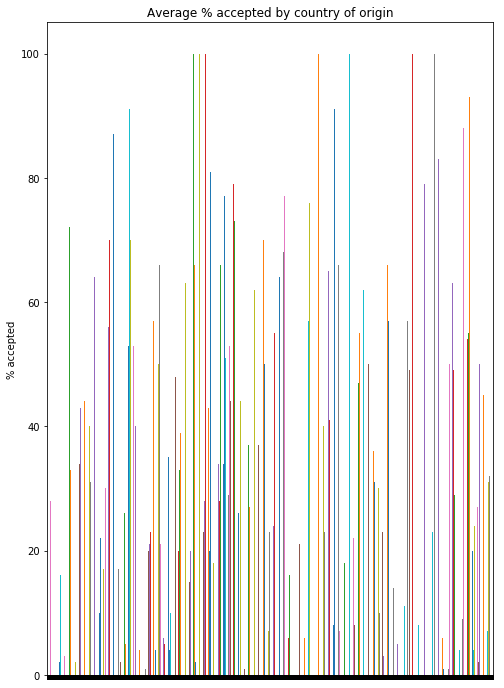

In [30]:
plt.figure(figsize=(8,12))

ax = df['percentage_accepted'].plot(kind='bar')

ax.set_ylabel('% accepted')
ax.set_title('Average % accepted by country of origin')
ax.set_xticklabels(df['percentage_accepted'].index.values, rotation=45, visible=False)

plt.show()

In [31]:
#df.sort_values(by=['percentage_accepted'], axis=1, ascending=True,na_position='last')

df.sort_values(by=['percentage_accepted'], ascending=False)


,Country / territory of asylum/residence,Origin,Year,Value,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
7477,Canada,South Sudan,2014,21,G / FI,0.0,0.0,10.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,100.0,0.0
3352,Australia,Burundi,2007,476,G / FI,0.0,0.0,7.0,6.0,0.0,0.0,0.0,6.0,1.0,0.0,100.0,0.0
6720,Australia,Somalia,2013,289,G / AR,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,100.0,0.0
8607,United States of America,Namibia,2015,1,G / EO,6.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,100.0,0.0
2865,Australia,Liberia,2006,710,G / FI,1.0,0.0,3.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,100.0,0.0
2863,Australia,Kuwait,2006,34,G / FI,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,0.0
2858,Australia,Iraq,2006,1961,G / AR,11.0,0.0,6.0,16.0,0.0,0.0,0.0,16.0,1.0,0.0,100.0,0.0
823,Australia,Guinea,2002,1,G / AR,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,100.0,0.0
6716,Australia,Saudi Arabia,2013,9,G / AR,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,0.0
8625,United States of America,Saudi Arabia,2015,5,G / EO,47.0,0.0,9.0,4.0,0.0,0.0,0.0,4.0,64.0,0.0,100.0,0.0


In [32]:
df.groupby('percentage_accepted').count().sort_values(by=['Origin'], ascending=False)

,Country / territory of asylum/residence,Origin,Year,Value,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_rejected
percentage_accepted,,,,,,,,,,,,,,,,
0.0,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128,3128
100.0,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228
1.0,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215
50.0,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204
33.0,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167
3.0,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
2.0,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157
25.0,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134
4.0,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133


## Combining target dataframes (2)

Combining asylees and demographics

In [33]:
demographics.columns.values

array(['Year', 'Country / territory of asylum/residence', 'Location Name',
       'Female 0-4', 'Female 5-11', 'Female 5-17', 'Female 12-17',
       'Female 18-59', 'Female 60+', 'F: Unknown', 'F: Total', 'Male 0-4',
       'Male 5-11', 'Male 5-17', 'Male 12-17', 'Male 18-59', 'Male 60+',
       'M: Unknown', 'M: Total'], dtype=object)

In [34]:
asydemo = pd.merge(demographics.drop(['Location Name'], axis=1), asylees.drop(['Origin', 'RSD procedure type / level'], axis=1), 
                   on=['Country / territory of asylum/residence', 
                                    'Year',])

In [35]:
asydemo.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,...,Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19.0,61.0
1,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20.0,46.0
2,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,6.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,100.0
3,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19.0,61.0
4,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20.0,46.0


In [36]:
len(asydemo)

584800

In [37]:
# asydemo = asydemo.groupby(['Year','Country / territory of asylum/residence']).sum()

In [38]:
colnames = asydemo.columns.values

print(colnames)

['Year' 'Country / territory of asylum/residence' 'Female 0-4'
 'Female 5-11' 'Female 5-17' 'Female 12-17' 'Female 18-59' 'Female 60+'
 'F: Unknown' 'F: Total' 'Male 0-4' 'Male 5-11' 'Male 5-17' 'Male 12-17'
 'Male 18-59' 'Male 60+' 'M: Unknown' 'M: Total' 'Tota pending start-year'
 'of which UNHCR-assisted(start-year)' 'Applied during year'
 'decisions_recognized' 'decisions_other' 'Rejected' 'Otherwise closed'
 'Total decisions' 'Total pending end-year'
 'of which UNHCR-assisted(end-year)' 'percentage_accepted'
 'percentage_rejected']


In [39]:
asydemo.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,...,Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19.0,61.0
1,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20.0,46.0
2,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,6.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,100.0
3,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19.0,61.0
4,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20.0,46.0


In [40]:
# if you groupby aand sum then the %s will need to be recalculated...

# overwriting the % recognized (accepted) for each row so its correct
asydemo['percentage_accepted'] = ((asydemo['decisions_recognized']) / (asydemo['Total decisions'])*100)

#if its < 0 or not a number just setting it to 0, otherwise making it an int
asydemo['percentage_accepted'] = asydemo['percentage_accepted'].apply(lambda x: 0 if not (x >= 0 and x <= 100) else int(x))

# % rejected
asydemo['percentage_rejected'] = ((asydemo['Rejected']) / (asydemo['Total decisions'])*100)

#if its less than 0 just setting it to 0, otherwise making it an int
asydemo['percentage_rejected'] = asydemo['percentage_rejected'].apply(lambda x: 0  if not (x >= 0 and x <= 100) else int(x))

# making sure all values are numeric and filling any NaNs that resulted with 0
#colnames = asydemo.columns.values
#asylees[colnames[4:]] = asylees[colnames[4:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0.0)

In [41]:
asydemo.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,...,Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19,61
1,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20,46
2,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,6.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0,100
3,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19,61
4,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20,46


In [42]:
asydemo = asydemo.fillna(0)

In [43]:
asydemo.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,...,Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,percentage_rejected
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19,61
1,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20,46
2,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,6.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0,100
3,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,110.0,21.0,0.0,68.0,21.0,110.0,0.0,0.0,19,61
4,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,15.0,3.0,0.0,7.0,5.0,15.0,0.0,0.0,20,46


In [44]:
asydemo[colnames[2:]] = asydemo[colnames[2:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)


In [45]:
for val in colnames:
    if '*'in asydemo[val]:
        print(val)

In [46]:
chekcing = asydemo.isin(['*'])

chekcing.sum().sum()

0

In [47]:
list(asydemo['Country / territory of asylum/residence'].unique())

asydemo['Country / territory of asylum/residence'].nunique()


187

In [48]:
regions = pd.read_csv(path+'countries_regions_from_iucnredlist.csv')


In [49]:
regions.head()

,Country,Region
0,Afghanistan,West & Central Asia
1,Åland Islands,Europe
2,Albania,Europe
3,Algeria,North Africa
4,American Samoa,Oceania


In [50]:
binarized = pd.get_dummies(regions['Region'])

In [51]:
#regions2 = pd.join(regions,binarized)

regions2 = pd.concat([regions, binarized], axis=1, join_axes=[regions.index])

In [52]:
regions2.head()

,Country,Region,Antarctic,Caribbean Islands,East Asia,Europe,Mesoamerica,North Africa,North America,North Asia,Oceania,South & South East Asia,South America,Sub-Saharan Africa,West & Central Asia
0,Afghanistan,West & Central Asia,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Åland Islands,Europe,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Albania,Europe,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Algeria,North Africa,0,0,0,0,0,1,0,0,0,0,0,0,0
4,American Samoa,Oceania,0,0,0,0,0,0,0,0,1,0,0,0,0


In [53]:
regions2 = regions2.rename(index=str, columns={"Country": "Country / territory of asylum/residence"})

In [54]:
asydemo2 = pd.merge(asydemo, regions2, on=['Country / territory of asylum/residence'])

In [55]:
asydemo2.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,...,Europe,Mesoamerica,North Africa,North America,North Asia,Oceania,South & South East Asia,South America,Sub-Saharan Africa,West & Central Asia
0,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
1,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
2,2001,Afghanistan,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,0,0,0,0,0,0,0,0,0,1
4,2001,Afghanistan,14335.0,0.0,45451.0,0.0,99880.0,19234.0,412004.0,590904.0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
asydemo2.columns.values

array(['Year', 'Country / territory of asylum/residence', 'Female 0-4',
       'Female 5-11', 'Female 5-17', 'Female 12-17', 'Female 18-59',
       'Female 60+', 'F: Unknown', 'F: Total', 'Male 0-4', 'Male 5-11',
       'Male 5-17', 'Male 12-17', 'Male 18-59', 'Male 60+', 'M: Unknown',
       'M: Total', 'Tota pending start-year',
       'of which UNHCR-assisted(start-year)', 'Applied during year',
       'decisions_recognized', 'decisions_other', 'Rejected',
       'Otherwise closed', 'Total decisions', 'Total pending end-year',
       'of which UNHCR-assisted(end-year)', 'percentage_accepted',
       'percentage_rejected', 'Region', 'Antarctic', 'Caribbean Islands',
       'East Asia', 'Europe', 'Mesoamerica', 'North Africa',
       'North America', 'North Asia', 'Oceania',
       'South & South East Asia', 'South America', 'Sub-Saharan Africa',
       'West & Central Asia'], dtype=object)

In [57]:
features = asydemo2.drop(['Region', 'Total decisions','decisions_recognized','Rejected'], axis=1)

## Feature selction

In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Create an SelectKBest object to select features with k best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=16)

#features = asydemo 
#.drop(['FlightNum', 'ArrDelay'], 1)

coltitles = features.columns.values

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(features.drop(['Country / territory of asylum/residence'], axis=1), features['percentage_accepted'])

print('Original number of features:', features.shape[1])
print('Reduced number of features:', X_kbest.shape[1])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [24 26] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Original number of features: 40
Reduced number of features: 16


In [59]:
idxs_selected = fvalue_selector.get_support(indices=True)

print(idxs_selected)


[ 0 17 18 19 21 22 23 24 25 27 28 29 32 35 37 38]


In [60]:
features_new = features.loc[:,coltitles[idxs_selected]]

In [61]:
features_new.head()

,Year,M: Total,Tota pending start-year,of which UNHCR-assisted(start-year),decisions_other,Otherwise closed,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,Antarctic,Caribbean Islands,East Asia,North Africa,Oceania,South America,Sub-Saharan Africa
0,2001,2.0,0.0,0.0,0.0,21.0,0.0,0.0,19.0,0,0,0,0,0,0,0
1,2001,2.0,0.0,0.0,0.0,5.0,0.0,0.0,20.0,0,0,0,0,0,0,0
2,2001,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,2001,625720.0,0.0,0.0,0.0,21.0,0.0,0.0,19.0,0,0,0,0,0,0,0
4,2001,625720.0,0.0,0.0,0.0,5.0,0.0,0.0,20.0,0,0,0,0,0,0,0


## Parameter optimization

In [ ]:
from __future__ import print_function

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
from sklearn import svm, grid_search, datasets

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
#clf.fit(iris.data, iris.target)

clf.fit(features_new.drop('percentage_accepted',1), features_new['percentage_accepted'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum num

## OLS

In [62]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import statsmodels.formula.api as smf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [63]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features_new.percentage_accepted.values.reshape(-1, 1)
X = features_new.drop('percentage_accepted',1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)



Coefficients: 
 [[-2.80946053e-01 -8.36599654e-07 -9.38845722e-04  1.46595183e-03
  -2.23277445e-04 -1.44922275e-04  1.89356145e-03 -1.61668760e-03
   2.07745670e-14  1.96806236e+01 -5.11229495e+00  3.79881982e+00
   1.30070818e+01 -2.16801780e-01  4.02343847e+00]]

Intercept: 
 [578.71390074]

R-squared:
0.013136536157409506


In [64]:
target2 = Y
data2 = X

X_train, X_test, y_train, y_test = train_test_split(data2, target2, test_size=0.2, random_state=20)

print('\nWith 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data2, target2).score(data2, target2)))



With 20% Holdout: 0.013782550556144859
Testing on Sample: 0.013136536157409506


### OLS on the original features dataframe

In [65]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features.percentage_accepted.values.reshape(-1, 1)
X = features.drop(['percentage_accepted', 'Country / territory of asylum/residence'],1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-3.98328404e-01  3.72677851e-01  3.72328956e-01  3.70602226e-01
   3.72467703e-01  3.72519140e-01  3.71466887e-01  3.72284743e-01
  -3.72375627e-01  4.40528851e-01  4.40396795e-01  4.42055267e-01
   4.40327557e-01  4.40482282e-01  4.41153960e-01  4.40620520e-01
  -4.40529361e-01  5.26201202e-03  6.58614291e-04  6.01539754e-03
  -6.93135091e-03 -6.18943891e-03 -5.19465674e-03 -7.20291231e-04
  -1.41379707e-01 -2.83120704e-15  1.51550425e+01 -7.26358162e+00
  -1.21228824e+01 -1.99918466e+00 -8.46051386e-01  1.41090511e+01
  -8.92513410e+00  8.54018729e+00  2.02321650e+00 -3.91290370e+00
  -1.38955801e+00 -3.36820148e+00]]

Intercept: 
 [822.51240596]

R-squared:
0.07600258393735926


In [66]:
target3 = Y
data3 = X

X_train, X_test, y_train, y_test = train_test_split(data3, target3, test_size=0.2, random_state=20)

print('\nWith 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data3, target3).score(data3, target3)))



With 20% Holdout: 0.07854759417812542
Testing on Sample: 0.07600258393735948


## Ridge Regression 

In [65]:
target = features_new.percentage_accepted.values.reshape(-1, 1)
data = features_new.drop('percentage_accepted',1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)


In [68]:
ridgeregr = linear_model.Ridge(alpha=16, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

0.011686553723595727
[ 6.77526800e-03 -9.99435037e-07 -8.30462320e-04  1.34617571e-03
 -2.70002951e-04 -1.41517474e-04  1.77086725e-03 -1.51222505e-03
  0.00000000e+00  2.02673889e+01 -5.61833644e+00  3.35527313e+00
  1.24898243e+01 -8.94866849e-02  3.94169312e+00]


In [69]:
print(ridgeregr.score(X_test, y_test))

0.012366254075123817


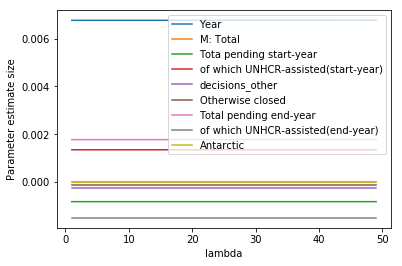

In [70]:
# Store estimates.
estimates = np.append(ridgeregr.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train, y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

In [65]:
ridgeregr2 = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), 
                                  fit_intercept=True, normalize=False, scoring=None, 
                                  cv=None, gcv_mode=None, store_cv_values=True)



In [66]:

ridgeregr2.fit(X_train, y_train)
print(ridgeregr2.score(X_train, y_train))
origparams = ridgeregr2.coef_[0]
print(origparams)

0.006707850053438991
[-2.78094827e-01 -3.93390656e-05 -8.38819891e-04  1.35246594e-03
 -2.77372659e-04 -1.37978932e-04  1.76009350e-03 -1.49131031e-03
  0.00000000e+00  2.02754683e+01 -5.12224730e+00  3.84546310e+00
  1.27337517e+01 -1.75651065e-01  3.93873552e+00]


In [67]:
print(ridgeregr2.score(X_test, y_test))

0.00783306396639849


In [70]:
print(ridgeregr2.cv_values_)

[[[167.8156212  167.81895298 167.85199833]]

 [[205.395107   205.39877883 205.43520917]]

 [[174.74773125 174.75113004 174.78484218]]

 ...

 [[191.2544466  191.25638378 191.27561697]]

 [[230.0372991  230.04117388 230.07962558]]

 [[ 56.89165935  56.89493357  56.92767195]]]


## Random Forest

In [62]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = features_new.drop('percentage_accepted',1)
Y = features_new['percentage_accepted']

#X = pd.get_dummies(X)
#X = X.dropna(axis=1)

In [63]:
scores = cross_val_score(rfc, X, Y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.06)


Feature ranking:
1. feature 6 (0.167968)
2. feature 5 (0.160590)
3. feature 2 (0.159971)
4. feature 7 (0.159024)
5. feature 3 (0.155687)
6. feature 1 (0.091614)
7. feature 0 (0.074322)
8. feature 4 (0.022718)
9. feature 14 (0.003080)
10. feature 11 (0.001678)
11. feature 10 (0.001577)
12. feature 13 (0.001032)
13. feature 9 (0.000577)
14. feature 12 (0.000163)
15. feature 8 (0.000000)


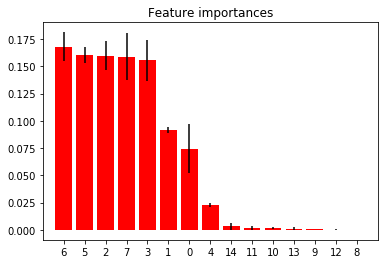

In [73]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X = features_new.drop('percentage_accepted',1)
y = features_new['percentage_accepted']

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [74]:
columnames = features_new.columns.values
for i, name in zip(range(len(columnames)), columnames):
    print(i,name)
    

0 Year
1 M: Total
2 Tota pending start-year
3 of which UNHCR-assisted(start-year)
4 decisions_other
5 Otherwise closed
6 Total pending end-year
7 of which UNHCR-assisted(end-year)
8 percentage_accepted
9 Antarctic
10 Caribbean Islands
11 East Asia
12 North Africa
13 Oceania
14 South America
15 Sub-Saharan Africa


In [87]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [76]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2003.29 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.728 (std: 0.008)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 8, 'min_samples_split': 6}

Model with rank: 2
Mean validation score: 0.726 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.726 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 7, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: 0.726 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.726 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_de

In [89]:
# that was a classifier, need to try the regression
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

# build a classifier
clf = ensemble.RandomForestRegressor(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"]}

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

rfc = ensemble.RandomForestRegressor(n_estimators=200, criterion='mse', 
    #                                  max_depth=None, max_features=2,
    #                        min_samples_leaf=8, min_samples_split=6
                                    )

#'bootstrap': False, 'criterion': 'gini', 
#        'max_depth': None, 'max_features': 2, 'min_samples_leaf': 8, 
#                    'min_samples_split': 6

X = features_new.drop('percentage_accepted',1)
Y = features_new['percentage_accepted']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0)

rfc.fit(X_train, y_train)

y_true, y_pred = y_test, rfc.predict(X_test)

print(rfc.score(X_test, y_test))

#sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

In [86]:
scores1 = cross_val_score(rfc, X_train, y_train, cv=10)

print(scores1)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

NameError: name 'rfc' is not defined

## SVM as Regression

In [ ]:
#from sklearn.svm import SVR
#import numpy as np
#y = features_new['percentage_accepted']
#X = features_new.drop('percentage_accepted',1)
#clf = SVR(C=1.0, epsilon=0.2)
#clf.fit(X, y) 

In [55]:
#scores = cross_val_score(clf, X, Y, cv=10)

#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.14 (+/- 0.17)


## KNN Regression

In [69]:
from sklearn import neighbors

In [74]:
features_new.head(1)

,Year,M: Total,Tota pending start-year,of which UNHCR-assisted(start-year),decisions_other,Otherwise closed,Total pending end-year,of which UNHCR-assisted(end-year),percentage_accepted,Antarctic,Caribbean Islands,East Asia,North Africa,Oceania,South America,Sub-Saharan Africa
0,2001,2.0,0.0,0.0,0.0,21.0,0.0,0.0,19.0,0,0,0,0,0,0,0


In [76]:
X = features_new.drop('percentage_accepted',1)
Y = features_new['percentage_accepted']


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0)

In [78]:
# trying to get he best number of neighbors w/ unweighted model

for i in range(1,18,4):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)

    knn.fit(X_train, y_train)

    y_true, y_pred = y_test, knn.predict(X_test)

    print('For {} neighbors: '.format(i))
    print(knn.score(X_test, y_test))


For 1 neighbors: 
-0.05584108014381939
For 5 neighbors: 
0.20991802385007652
For 9 neighbors: 
0.2171754186441156
For 13 neighbors: 
0.2110294502295621


In [79]:
# i want to try out 1 more
knn = neighbors.KNeighborsRegressor(n_neighbors=18)

knn.fit(X_train, y_train)

y_true, y_pred = y_test, knn.predict(X_test)

print('For {} neighbors: '.format('18'))
print(knn.score(X_test, y_test))

For 18 neighbors: 
0.2018860834884334


In [82]:
# trying to get he best number of neighbors
# when i tried it with the previous range

# For 1 neighbors: 
#-0.05584108014381939
#For 5 neighbors: 
#0.25788103736100465
#For 9 neighbors: 
#0.2865834286001335

for i in range(13,34,4):
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    knn_w.fit(X_train, y_train)

    y_true, y_pred = y_test, knn_w.predict(X_test)

    print('For {} neighbors: '.format(i))
    print(knn_w.score(X_test, y_test))


For 13 neighbors: 
0.2936968482164447
For 17 neighbors: 
0.29615288194679246
For 21 neighbors: 
0.29660453966261
For 25 neighbors: 
0.2966780606316911
For 29 neighbors: 
0.2963773195801682
For 33 neighbors: 
0.2957352647280912


In [83]:
# trying one more

knn_w = neighbors.KNeighborsRegressor(n_neighbors=27, weights='distance')
    
knn_w.fit(X_train, y_train)

y_true, y_pred = y_test, knn_w.predict(X_test)

print('For {} neighbors: '.format('27'))
print(knn_w.score(X_test, y_test))

For 27 neighbors: 
0.2964740402089797


In [85]:
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.11 (+/- 0.19)
Weighted Accuracy: -0.10 (+/- 0.17)
